In [1539]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [1540]:
pred_org = cv2.imread('samples/pred_2.png')
pred = cv2.cvtColor(pred_org, cv2.COLOR_BGR2GRAY)
org = cv2.imread('samples/img_2.png')
mask = cv2.imread('samples/mask_2.png')

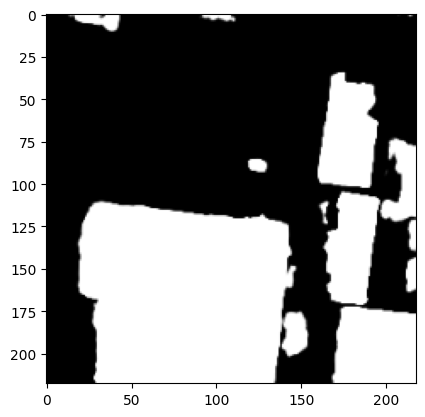

In [1541]:
plt.imshow(pred, cmap='gray')
plt.show()

In [1542]:
# step 1 :threshold and shrink mask (remove false positives and have better separation between buildings)
_, thresh = cv2.threshold(pred, 200, 255, cv2.THRESH_BINARY)
thresh_eroded_1 = cv2.erode(thresh, np.ones((5,5), np.uint8), cv2.BORDER_CONSTANT,iterations=1)
thresh_eroded_2 = cv2.erode(thresh_eroded_1, np.ones((3,3), np.uint8), cv2.BORDER_CONSTANT,iterations=2)
thresh_eroded_3 = cv2.erode(thresh_eroded_2, np.ones((2,2), np.uint8), cv2.BORDER_CONSTANT,iterations=3) 

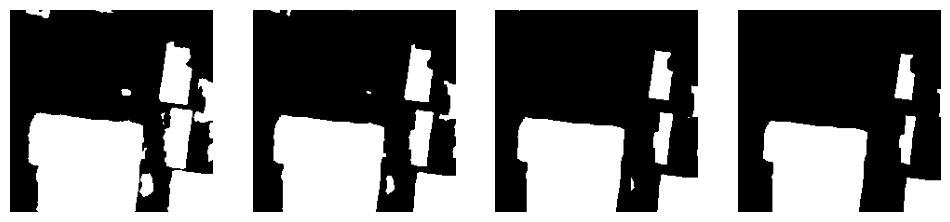

In [1543]:
fig, ax = plt.subplots(1,4, figsize=(12,15))
ax[0].imshow(thresh, cmap='gray')
ax[0].axis('off')
ax[1].imshow(thresh_eroded_1, cmap='gray')
ax[1].axis('off')
ax[2].imshow(thresh_eroded_2, cmap='gray')
ax[2].axis('off')
ax[3].imshow(thresh_eroded_3, cmap='gray')
ax[3].axis('off')
plt.show()

In [1544]:
# step 2 : find countours
contours,_ = cv2.findContours(thresh_eroded_3, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [1545]:
# step 3 : straighten contour to quadrilateral (reduce number of corners to be under 6)
approx_cnt = []
for cnt in contours:
    epsilon = 0.0008*cv2.arcLength(cnt,True)
    while True:
        epsilon += epsilon
        approx = cv2.approxPolyDP(cnt,epsilon,True)
        if len(approx) <= 6:
            approx_cnt.append(approx)
            break

In [1546]:
# view how many corners each contour has
for appr in approx_cnt:
    print(len(appr))

4
6
5
4
4
1


In [1547]:
thresh_eroded_rgb = cv2.cvtColor(thresh_eroded_3, cv2.COLOR_GRAY2RGB)

In [1548]:
def show_contours(contours):
    img_org = cv2.drawContours(org.copy(), contours, -1, (255,0,255), 1)
    img_mask = cv2.drawContours(mask.copy(), contours, -1, (255,0,255), 1)
    img_pred = cv2.drawContours(pred_org.copy(), contours, -1, (255,0,255), 1)
    img_processed = cv2.drawContours(thresh_eroded_rgb.copy(), contours, -1, (255,0,255), 1)

    fig, ax = plt.subplots(1,4, figsize=(12,15))

    ax[0].set_title('image')
    ax[0].imshow(img_org, cmap='gray')
    ax[0].axis('off')
    ax[1].set_title('true mask')
    ax[1].imshow(img_mask, cmap='gray')
    ax[1].axis('off')
    ax[2].set_title('pred mask')
    ax[2].imshow(img_pred, cmap='gray')
    ax[2].axis('off')
    ax[3].set_title('postprocessed mask')
    ax[3].imshow(img_processed, cmap='gray')
    ax[3].axis('off')

    plt.show()

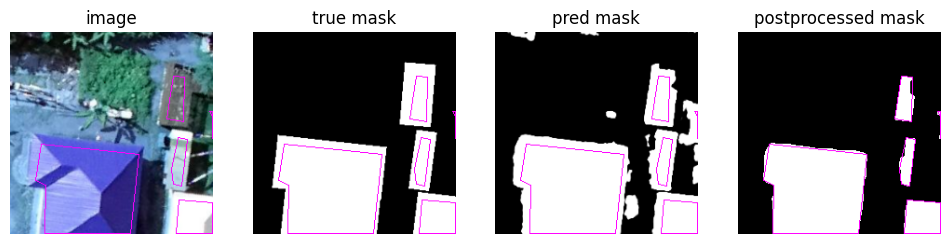

In [1549]:
show_contours(approx_cnt)

In [1550]:
# step 4 : Rescale contour back to recover area shrunk by the erode function
def scale_contour(cnts, scale):
    cnts_scaled = []
    for cnt in cnts :
        M = cv2.moments(cnt)
        cx = int(M['m10']/(M['m00']+0.0000001))
        cy = int(M['m01']/(M['m00']+0.0000001))

        cnt_norm = cnt - [cx, cy]
        cnt_scaled = cnt_norm * scale
        cnt_scaled = cnt_scaled + [cx, cy]
        cnt_scaled = cnt_scaled.astype(np.int32)
        cnts_scaled.append(cnt_scaled)

    return cnts_scaled

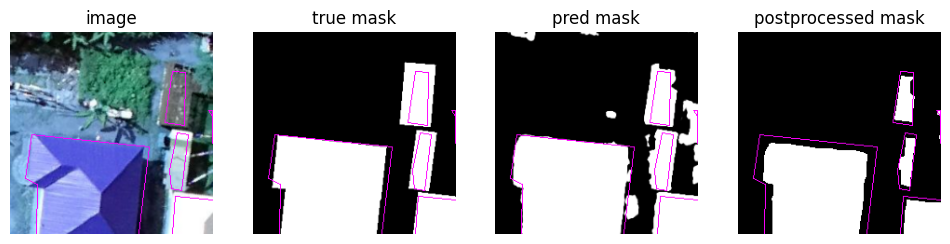

In [1551]:
scaled_approx_cnt = scale_contour(approx_cnt, 1.2)
show_contours(scaled_approx_cnt)